# ClusterFinder 74 validation BGCs check

This notebook validates the 6 genomes with 74 BGCs used for ClusterFinder positive rate evaluation.

In [1]:
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation
import pandas as pd
from Bio import Entrez
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib
font = {'family': 'Arial', 'size': 12}
matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=11, handlelength=2)

def get_features_of_type(sequence, feature_type):
    return [feature for feature in sequence.features if feature.type == feature_type]

In [2]:
import sys
sys.path.append('..')
sys.path.append('../bgc_detection')

from bgc_detection.run_prediction import run_prediction
from bgc_detection.pipeline import PipelineWrapper
from bgc_detection.evaluation import evaluation_plots
from bgc_detection.evaluation.confusion_matrix import confusion_matrix, get_threshold

/Users/prihodad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def get_reference_gene_location(gene_csv_row):
    start = gene_csv_row['gene start'] - 1
    end = gene_csv_row['gene stop']
    strand = 1 if gene_csv_row['gene strand'] == '+' else (-1 if gene_csv_row['gene strand'] == '-' else None)
    return FeatureLocation(start, end, strand)

def feature_locus_matches(feature, reference_locus):
     return feature.qualifiers.get('locus_tag',[None])[0] == reference_locus

In [4]:
bgcs = pd.read_csv('../data/clusterfinder/74validation/74validation_locations.csv')
#bgcs = bgcs.drop_duplicates()
bgcs.head()

,Accession,Organism,BGC_start,BGC_stop,Locus_start,Locus_end
0,AM746676.1,Sorangium cellulosum So ce 56,5761328,5853706,sce4132,sce4138
1,AM746676.1,Sorangium cellulosum So ce 56,4373490,4462891,sce3185,sce3196
2,AM746676.1,Sorangium cellulosum So ce 56,11484644,11529102,sce8254,sce8262
3,AM746676.1,Sorangium cellulosum So ce 56,5398169,5418126,sce3879,sce3891
4,AM746676.1,Sorangium cellulosum So ce 56,1150403,1167578,sce0818,sce0820


In [5]:
#bgcs = bgcs[bgcs['Accession'].apply(lambda c: c.startswith('NC_004129') or c.startswith('AP009493') or c.startswith('NC_009380'))]
#bgcs['Accession'].unique()

In [6]:
print('\n'.join(bgcs['Organism'].unique()))

Sorangium cellulosum So ce 56
Salinispora tropica CNB-440
Streptomyces griseus griseus NBRC 13350
Saccharopolyspora erythraea NRRL 2338
Pseudomonas fluorescens Pf-5
Anabaena variabilis ATCC 29413


In [7]:
#bgcs = bgcs[bgcs['Accession'] != 'NC_007413.1']
print('BGCs:', len(bgcs))
contig_ids = bgcs['Accession'].unique()
print('Contigs:', len(contig_ids))
contig_ids

BGCs: 75
Contigs: 6


array(['AM746676.1', 'NC_009380.1', 'AP009493.1', 'AM420293.1',
       'NC_004129.6', 'NC_007413.1'], dtype=object)

In [8]:
def check_gene_found(locus_id, location_start, location_end, genes_by_locus):
    gene = genes_by_locus.get(locus_id)
    if not gene:
        print('Start gene {} not found'.format(locus_id))
        return False
    if location_start is not None and location_start != gene.location.start:
        print('Expected start location {}, got {} ({}) for gene {}'.format(location_start, gene.location.start, (location_start-gene.location.start), locus_id))
        return False
    if location_end is not None and location_end != gene.location.end:
        print('Expected end location {}, got {} ({}) for gene {}'.format(location_end, gene.location.end, (location_end-gene.location.end), locus_id))
        return False
    return True

In [9]:
records = SeqIO.parse('../data/clusterfinder/74validation/74validation_contigs.gbk', 'genbank')
for record in records:
    record_bgcs = bgcs[bgcs['Accession']==record.id]
    record_genes = get_features_of_type(record, 'gene')
    genes_by_locus = {locus: gene for gene in record_genes for locus in gene.qualifiers.get('locus_tag',[]) + gene.qualifiers.get('old_locus_tag',[])}
    for i,bgc in record_bgcs.iterrows():
        s = check_gene_found(bgc['Locus_start'], bgc['BGC_start'] - 1, None, genes_by_locus)
        e = check_gene_found(bgc['Locus_end'], None, bgc['BGC_stop'], genes_by_locus)
        if not s or not e:    
            print(record.id, bgc['BGC_start'], bgc['BGC_stop'])
            print('-'*80)
print('All checked.')

All checked.


# Evaluations

In [10]:
def get_results(predictions, bgcs):
    results = []
    for contig_id in contig_ids:
        record_bgcs = bgcs[bgcs['Accession']==contig_id]
        record_pred = predictions[predictions['contig_id'] == contig_id]
        for i,bgc in record_bgcs.iterrows():
            bgc_start = bgc['BGC_start']
            bgc_end = bgc['BGC_stop']
            bgc_predictions = record_pred[(record_pred['gene_end'] >= bgc_start) & (record_pred['gene_start'] <= bgc_end)]['prediction']
            pred_median = np.median(bgc_predictions)
            pred_max = np.max(bgc_predictions)
            results.append({
                'contig_id':contig_id, 
                'BGC_start':bgc_start, 
                'BGC_stop':bgc_end, 
                'num_domains': len(bgc_predictions), 
                'pred_median': pred_median, 
                'pred_max': pred_max}
            )
    results = pd.DataFrame(results)[['contig_id','BGC_start','BGC_stop','num_domains','pred_median','pred_max']]

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(results.sort_values(by='pred_median', ascending=False).reset_index(drop=True)[-10:])

    return results

In [11]:
def get_non_bgc_predictions(predictions, bgcs):
    results = []
    for contig_id in contig_ids:
        record_bgcs = bgcs[bgcs['Accession']==contig_id]
        record_pred = predictions[predictions['contig_id'] == contig_id]
        positives = []
        for i, bgc in record_bgcs.iterrows():
            bgc_start = bgc['BGC_start']
            bgc_end = bgc['BGC_stop']
            bgc_predictions = record_pred[(record_pred['gene_end'] > bgc_start) & (record_pred['gene_start'] < bgc_end)]['prediction']
            positives.append(bgc_predictions.index.values)
        results.append(record_pred.drop(np.concatenate(positives)))
    return pd.concat(results)

In [12]:
def prediction_hist(predictions):
    ax = predictions['prediction'].hist(bins=20)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Frequency')
    ax.set_title(vals)
    plt.show()

In [13]:
def evaluate(results, predictions, threshold, verbose=1):
    num_detected = sum(results['pred_median'] >= threshold)
    detected = num_detected/len(results)*100
    non_bgc_predictions = get_non_bgc_predictions(predictions, bgcs)
    non_bgc_positive = sum(non_bgc_predictions['prediction'] >= threshold)
    non_bgc_positive_fraction = non_bgc_positive / len(non_bgc_predictions) * 100
    if verbose:
        print('')
        print('Detected BGCs >= {}: {} ({:.1f}% median BGC-wise recall)'.format(threshold, num_detected, detected))
        print('')
        print('Prediction has {:.1f}% domain-wise FPR if considering not annotated sequence as negative (non-BGC)'.format(non_bgc_positive_fraction))
    #prediction_hist(predictions)
    return detected, non_bgc_positive_fraction

In [14]:
all_domains = pd.read_csv('../data/clusterfinder/74validation/74validation_domains.csv')
domains = all_domains[all_domains['evalue'] < 0.01].copy()

In [15]:
idx_missing = all_domains
idx_missing = idx_missing[idx_missing['contig_id']=='AM420293.1']
idx_missing = idx_missing[idx_missing['gene_end'] >= 3520071]
idx_missing = idx_missing[idx_missing['gene_start'] <= 3522347]
idx_missing

,contig_id,locus_tag,protein_id,gene_start,gene_end,gene_strand,pfam_id,domain_start,domain_end,evalue,bitscore
59717,AM420293.1,SACE_3187,CAM02463.1,3520070,3522347,-1,PF03936,549,673,0.068,12.4


In [16]:
domains_missing = all_domains.loc[np.min(idx_missing.index.values)-1:np.max(idx_missing.index.values)+1]
domains_missing;

In [17]:
def is_domain_in_cluster(domain):
    record_bgcs = bgcs[bgcs['Accession']==domain['contig_id']]
    for i, bgc in record_bgcs.iterrows():
        bgc_start = bgc['BGC_start']
        bgc_end = bgc['BGC_stop']
        if domain['gene_end'] > bgc_start and domain['gene_start'] < bgc_end:
            return 1
    return 0

In [18]:
def count_y_clusters(y):
    prev = 0
    clusters = 0
    for val in y:
        if val == 1 and prev == 0:
            clusters += 1
        prev = val
    return clusters

In [19]:
domains['in_cluster'] = domains.apply(is_domain_in_cluster, axis=1)

# LSTM pfam2vec

In [20]:
path = '../data/models/trained/16lstm-100pfamdim-8pfamiter-posweighted-neg-10k.pickle'
predictions_lstm = run_prediction(domains, PipelineWrapper.load(path))

Using TensorFlow backend.


Predicting 6 samples...
Batch matrix shape (1, 15614, 102)
Batch matrix shape (1, 18496, 102)
Batch matrix shape (1, 15126, 102)
Batch matrix shape (1, 13978, 102)
Batch matrix shape (1, 11712, 102)
Batch matrix shape (1, 9612, 102)


In [35]:
def plot_contigs(predictions, color=None, **kwargs):
    num_contigs = len(predictions.groupby('contig_id'))
    fig, axes = plt.subplots(num_contigs, 1, figsize=(13, num_contigs*0.7))
    i = 0
    for contig_id, contig_domains in predictions.groupby('contig_id'):
        in_cluster = contig_domains.reset_index()['in_cluster']
        num_bgcs = count_y_clusters(in_cluster)
        title = '{} ({} BGCs)'.format(contig_id, num_bgcs)
        ax = in_cluster.plot(title=title, color='#333333', label='True BGCs', lw=0.3, alpha=0.5, ax=axes[i])
        in_cluster.plot(kind='area', ax=ax, color='grey', alpha=0.5, label='')
        lstm_pred = contig_domains.reset_index()['prediction']
        lstm_pred.reset_index(drop=True).plot(kind='area', label='', color=color, ax=ax, alpha=0.1)
        lstm_pred.reset_index(drop=True).plot(ax=ax, color=color, **kwargs, lw=0.3, alpha=0.5)
        ax.get_xaxis().set_ticks([])
        i += 1 
    plt.legend().remove()
    plt.tight_layout()
    return fig

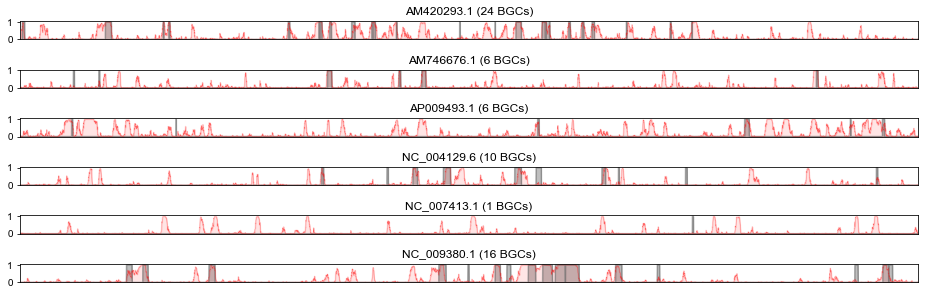

In [36]:
fig = plot_contigs(predictions_lstm, color='red', label='DeepBGC')
fig.savefig('../data/figures/paper/supplementary/S3a.png', bbox_inches='tight', dpi=600)

In [37]:
results_lstm = get_results(predictions_lstm, bgcs)
evaluate(results_lstm, predictions_lstm, 0.4)

/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


      contig_id  BGC_start  BGC_stop  num_domains  pred_median  pred_max
65   AM420293.1    4075163   4078403            8     0.038335  0.053094
66  NC_007413.1    4798900   4805360           14     0.027314  0.061494
67  NC_004129.6    4150446   4188442           81     0.020844  0.156813
68  NC_004129.6    4150446   4188442           81     0.020844  0.156813
69  NC_004129.6    5361649   5378019           25     0.014552  0.068481
70  NC_004129.6    5361649   5378019           25     0.014552  0.068481
71   AP009493.1    1490671   1492896            5     0.014034  0.034996
72  NC_004129.6    2852686   2855655           20     0.003690  0.006600
73  NC_004129.6    2852686   2855655           20     0.003690  0.006600
74   AM420293.1    3520071   3522347            0          NaN       NaN

Detected BGCs >= 0.4: 52 (69.3% median BGC-wise recall)

Prediction has 9.5% domain-wise FPR if considering not annotated sequence as negative (non-BGC)


(69.33333333333334, 9.500012218665233)

In [38]:
predictions_missing = run_prediction(domains_missing, PipelineWrapper.load(path))
print(np.median(predictions_missing['prediction']))
predictions_missing

Predicting 1 samples...
0.9991930179199398


,contig_id,locus_tag,protein_id,gene_start,gene_end,gene_strand,pfam_id,domain_start,domain_end,evalue,bitscore,prediction
59716,AM420293.1,SACE_3186,CAM02462.1,3518882,3520061,1,PF00481,35,60,4.800000e-01,9.9,0.046708
59717,AM420293.1,SACE_3187,CAM02463.1,3520070,3522347,-1,PF03936,549,673,6.800000e-02,12.4,0.999227
59718,AM420293.1,SACE_3189,CAM02465.1,3523365,3524559,-1,PF00067,260,362,2.800000e-11,42.7,0.999193


LSTM confusion matrix (threshold 0.40000)
                   Labelled BGC  Labelled non-BGC   
Predicted BGC              2102              7775  0
Predicted non-BGC           594             74067  0
                              0                 0  0


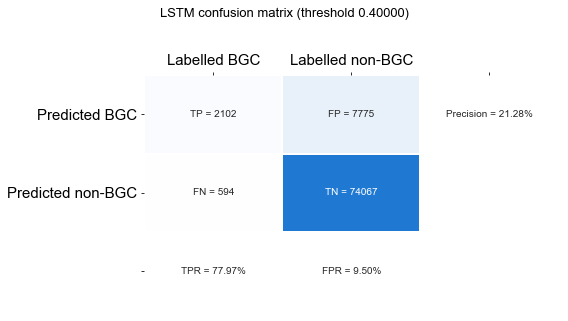

In [39]:
confusion_matrix(predictions_lstm['in_cluster'], predictions_lstm['prediction'], threshold=0.4, title='LSTM confusion matrix');

# AntiSMASH ClusterFinder out of the box

In [40]:
predictions_cf_orig = pd.read_csv('../data/clusterfinder/74validation/prediction/antismash_clusterfinder.csv')
predictions_cf_orig.head()

,contig_id,gene_start,gene_end,gene_strand,locus_tag,protein_id,pfam_id,evalue,prediction
0,NC_007413.1,118,1501,1,Ava_0001,YP_320522.1,PF11638,1.700000e-16,0.025971
1,NC_007413.1,118,1501,1,Ava_0001,YP_320522.1,PF00308,4.800000e-88,0.021154
2,NC_007413.1,118,1501,1,Ava_0001,YP_320522.1,PF01695,2.300000e-12,0.050774
3,NC_007413.1,118,1501,1,Ava_0001,YP_320522.1,PF00004,4.100000e-04,0.035423
4,NC_007413.1,118,1501,1,Ava_0001,YP_320522.1,PF08299,1.100000e-27,0.000417


In [41]:
predictions_cf_orig['in_cluster'] = predictions_cf_orig.apply(is_domain_in_cluster, axis=1)

In [42]:
results_cf_orig = get_results(predictions_cf_orig, bgcs)
evaluate(results_cf_orig, predictions_cf_orig, 0.4)

      contig_id  BGC_start  BGC_stop  num_domains  pred_median  pred_max
65  NC_009380.1    1140547   1182556           65     0.914891  0.999998
66  NC_009380.1    3720230   3730595           30     0.912706  0.999956
67   AM420293.1    4360969   4366991            5     0.868946  0.952157
68  NC_009380.1     660116    691012           74     0.773724  1.000000
69   AP009493.1    1490671   1492896            7     0.767512  0.861961
70  NC_009380.1    2634594   2642202           14     0.596560  0.988073
71   AM420293.1    3563550   3573825           14     0.532148  0.996154
72  NC_004129.6    5361649   5378019           33     0.316494  0.997750
73  NC_004129.6    5361649   5378019           33     0.316494  0.997750
74  NC_009380.1    2857126   2875505           43     0.305544  0.999978

Detected BGCs >= 0.4: 72 (96.0% median BGC-wise recall)

Prediction has 42.9% domain-wise FPR if considering not annotated sequence as negative (non-BGC)


(96.0, 42.93495774384349)

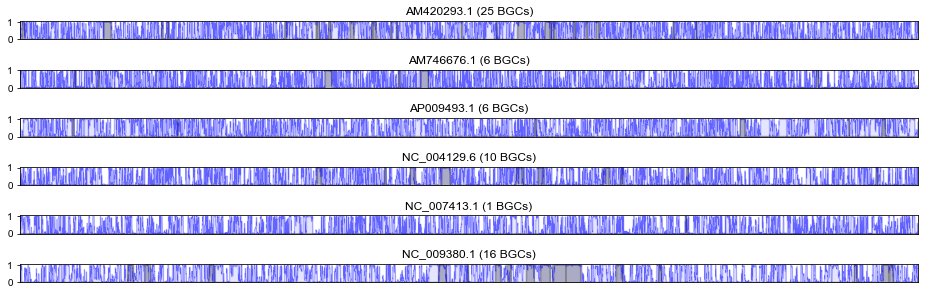

In [43]:
fig = plot_contigs(predictions_cf_orig, color='blue', label='ClusterFinder (original)')
fig.savefig('../data/figures/paper/supplementary/S3b.png', bbox_inches='tight', dpi=600)

In [44]:
print(classification_report(predictions_cf_orig['in_cluster'], predictions_cf_orig['prediction'] > 0.4))

             precision    recall  f1-score   support

          0       0.99      0.57      0.73     96199
          1       0.07      0.92      0.14      3596

avg / total       0.96      0.58      0.70     99795



ClusterFinder confusion matrix (threshold 0.40000)
                   Labelled BGC  Labelled non-BGC   
Predicted BGC              3312             41303  0
Predicted non-BGC           284             54896  0
                              0                 0  0


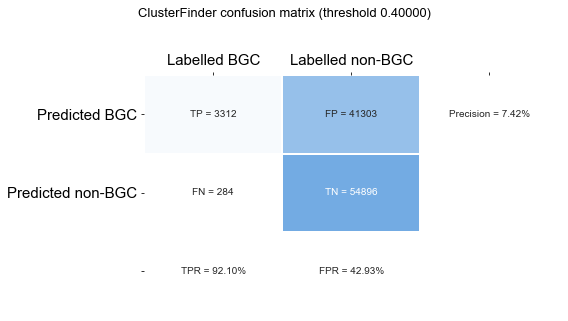

In [45]:
confusion_matrix(predictions_cf_orig['in_cluster'], predictions_cf_orig['prediction'], threshold=0.4, title='ClusterFinder confusion matrix');

# HMM retrained

In [46]:
path = '../data/models/trained/hmm_discrete.bgc_blast.pickle'
predictions_retrained = run_prediction(domains, PipelineWrapper.load(path))

Predicting 6 samples...


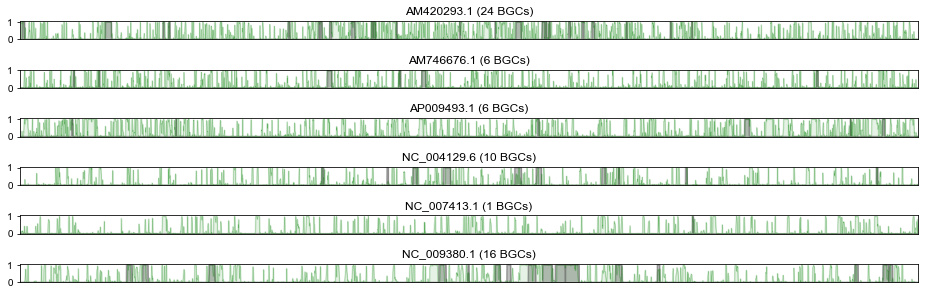

In [47]:
fig = plot_contigs(predictions_retrained, color='green', label='ClusterFinder (retrained)')
fig.savefig('../data/figures/paper/supplementary/S3c.png', bbox_inches='tight', dpi=600)

In [48]:
results_retrained = get_results(predictions_retrained, bgcs)
evaluate(results_retrained, predictions_retrained, 0.4)

/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      contig_id  BGC_start  BGC_stop  num_domains  pred_median  pred_max
65  NC_004129.6    4150446   4188442           81     0.047635  0.999986
66  NC_004129.6    4150446   4188442           81     0.047635  0.999986
67  NC_009380.1    2857126   2875505           40     0.028775  0.091086
68   AM420293.1    4360969   4366991            3     0.012937  0.102069
69  NC_004129.6    4706381   4759615           56     0.012522  0.999978
70  NC_004129.6    4706381   4759615           56     0.012522  0.999978
71  NC_009380.1    2634594   2642202           11     0.003295  0.548506
72  NC_004129.6    5361649   5378019           25     0.000956  0.996013
73  NC_004129.6    5361649   5378019           25     0.000956  0.996013
74   AM420293.1    3520071   3522347            0          NaN       NaN

Detected BGCs >= 0.4: 61 (81.3% median BGC-wise recall)

Prediction has 19.2% domain-wise FPR if considering not annotated sequence as negative (non-BGC)


(81.33333333333333, 19.152757752743092)

In [49]:
def plot_approx_roc(results, predictions, ax, **kwargs):
    tprs = []
    fprs = []
    thresholds = [0] + list(results['pred_median'].sort_values().values) + [1]
    print('{} thresholds'.format(len(thresholds)))
    for t in thresholds:
        tpr, fpr = evaluate(results, predictions, t, verbose=0)
        #print(t, fpr, tpr)
        tprs.append(tpr)
        fprs.append(fpr)
    ax.step(fprs, tprs, **kwargs)

77 thresholds
77 thresholds
77 thresholds


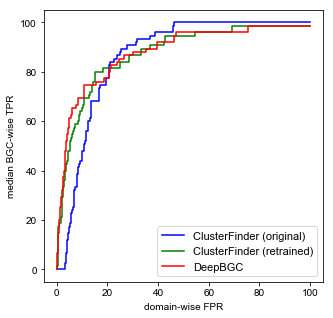

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_approx_roc(results_cf_orig, predictions_cf_orig, ax=ax, color='blue', label='ClusterFinder (original)')
plot_approx_roc(results_retrained, predictions_retrained, ax=ax, color='green', label='ClusterFinder (retrained)')
plot_approx_roc(results_lstm, predictions_lstm, ax=ax, color='red', label='DeepBGC')
ax.set_xlabel('domain-wise FPR')
ax.set_ylabel('median BGC-wise TPR')
ax.legend()

: 0.847 AUC
: 0.870 AUC
: 0.923 AUC


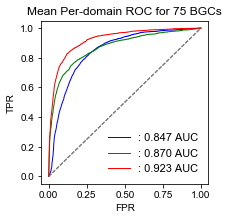

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
evaluation_plots.plot_roc_curve(predictions_cf_orig['in_cluster'], predictions_cf_orig['prediction'], ax=ax, label='', color='blue')
evaluation_plots.plot_roc_curve(predictions_retrained['in_cluster'], predictions_retrained['prediction'], ax=ax, label='', color='green', title='Per-domain ROC')
evaluation_plots.plot_roc_curve(predictions_lstm['in_cluster'], predictions_lstm['prediction'], ax=ax, label='', color='red', title='Mean Per-domain ROC for 75 BGCs')

fig.savefig('../data/figures/paper/main/3c.pdf', dpi=150, bbox_inches='tight')

# Results at 10% FPR

LSTM confusion matrix (threshold 0.37354)
      contig_id  BGC_start  BGC_stop  num_domains  pred_median  pred_max
65   AM420293.1    4075163   4078403            8     0.039337  0.053204
66  NC_007413.1    4798900   4805360           14     0.035754  0.072652
67  NC_004129.6    4150446   4188442           81     0.019131  0.152310
68  NC_004129.6    4150446   4188442           81     0.019131  0.152310
69   AP009493.1    1490671   1492896            5     0.015556  0.036319
70  NC_004129.6    5361649   5378019           25     0.014241  0.052824
71  NC_004129.6    5361649   5378019           25     0.014241  0.052824
72  NC_004129.6    2852686   2855655           20     0.003470  0.007846
73  NC_004129.6    2852686   2855655           20     0.003470  0.007846
74   AM420293.1    3520071   3522347            0          NaN       NaN


/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)



Detected BGCs >= 0.3735433518886566: 52 (69.3% median BGC-wise recall)

Prediction has 10.0% domain-wise FPR if considering not annotated sequence as negative (non-BGC)


(69.33333333333334, 9.99853376017204)

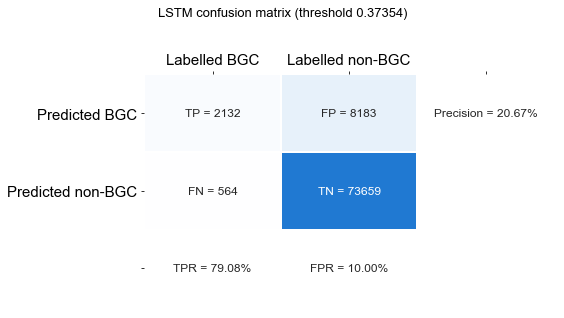

In [50]:
lstm_threshold = get_threshold(predictions_lstm['in_cluster'], predictions_lstm['prediction'], target_fpr=0.1)
confusion_matrix(predictions_lstm['in_cluster'], predictions_lstm['prediction'], threshold=lstm_threshold, title='LSTM confusion matrix')
evaluate(get_results(predictions_lstm, bgcs), predictions_lstm, lstm_threshold)

ClusterFinder confusion matrix (threshold 0.99767)
      contig_id  BGC_start  BGC_stop  num_domains  pred_median  pred_max
65  NC_009380.1    1140547   1182556           65     0.914891  0.999998
66  NC_009380.1    3720230   3730595           30     0.912706  0.999956
67   AM420293.1    4360969   4366991            5     0.868946  0.952157
68  NC_009380.1     660116    691012           74     0.773724  1.000000
69   AP009493.1    1490671   1492896            7     0.767512  0.861961
70  NC_009380.1    2634594   2642202           14     0.596560  0.988073
71   AM420293.1    3563550   3573825           14     0.532148  0.996154
72  NC_004129.6    5361649   5378019           33     0.316494  0.997750
73  NC_004129.6    5361649   5378019           33     0.316494  0.997750
74  NC_009380.1    2857126   2875505           43     0.305544  0.999978

Detected BGCs >= 0.997671058286: 34 (45.3% median BGC-wise recall)

Prediction has 10.0% domain-wise FPR if considering not annotated sequence as

(45.33333333333333, 9.999064439339286)

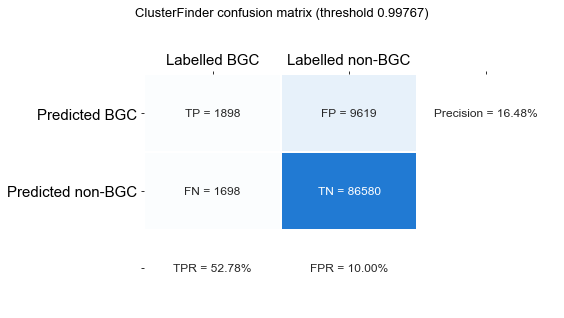

In [51]:
cf_threshold = get_threshold(predictions_cf_orig['in_cluster'], predictions_cf_orig['prediction'], target_fpr=0.1)
confusion_matrix(predictions_cf_orig['in_cluster'], predictions_cf_orig['prediction'], threshold=cf_threshold, title='ClusterFinder confusion matrix')
evaluate(get_results(predictions_cf_orig, bgcs), predictions_cf_orig, cf_threshold)

# Results at 80% TPR

LSTM confusion matrix (threshold 0.33724)
      contig_id  BGC_start  BGC_stop  num_domains  pred_median  pred_max
65   AM420293.1    4075163   4078403            8     0.039337  0.053204
66  NC_007413.1    4798900   4805360           14     0.035754  0.072652
67  NC_004129.6    4150446   4188442           81     0.019131  0.152310
68  NC_004129.6    4150446   4188442           81     0.019131  0.152310
69   AP009493.1    1490671   1492896            5     0.015556  0.036319
70  NC_004129.6    5361649   5378019           25     0.014241  0.052824
71  NC_004129.6    5361649   5378019           25     0.014241  0.052824
72  NC_004129.6    2852686   2855655           20     0.003470  0.007846
73  NC_004129.6    2852686   2855655           20     0.003470  0.007846
74   AM420293.1    3520071   3522347            0          NaN       NaN


/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/prihodad/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)



Detected BGCs >= 0.33723604679107666: 54 (72.0% median BGC-wise recall)

Prediction has 10.7% domain-wise FPR if considering not annotated sequence as negative (non-BGC)


(72.0, 10.688888345837102)

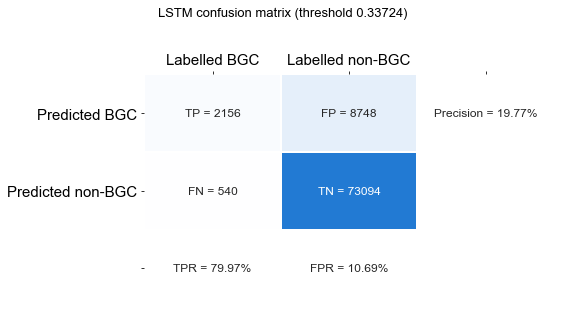

In [52]:
lstm_threshold = get_threshold(predictions_lstm['in_cluster'], predictions_lstm['prediction'], target_tpr=0.8)
confusion_matrix(predictions_lstm['in_cluster'], predictions_lstm['prediction'], threshold=lstm_threshold, title='LSTM confusion matrix')
evaluate(get_results(predictions_lstm, bgcs), predictions_lstm, lstm_threshold)

ClusterFinder confusion matrix (threshold 0.92798)
      contig_id  BGC_start  BGC_stop  num_domains  pred_median  pred_max
65  NC_009380.1    1140547   1182556           65     0.914891  0.999998
66  NC_009380.1    3720230   3730595           30     0.912706  0.999956
67   AM420293.1    4360969   4366991            5     0.868946  0.952157
68  NC_009380.1     660116    691012           74     0.773724  1.000000
69   AP009493.1    1490671   1492896            7     0.767512  0.861961
70  NC_009380.1    2634594   2642202           14     0.596560  0.988073
71   AM420293.1    3563550   3573825           14     0.532148  0.996154
72  NC_004129.6    5361649   5378019           33     0.316494  0.997750
73  NC_004129.6    5361649   5378019           33     0.316494  0.997750
74  NC_009380.1    2857126   2875505           43     0.305544  0.999978

Detected BGCs >= 0.9279845928329999: 65 (86.7% median BGC-wise recall)

Prediction has 24.3% domain-wise FPR if considering not annotated sequenc

(86.66666666666667, 24.25908793230699)

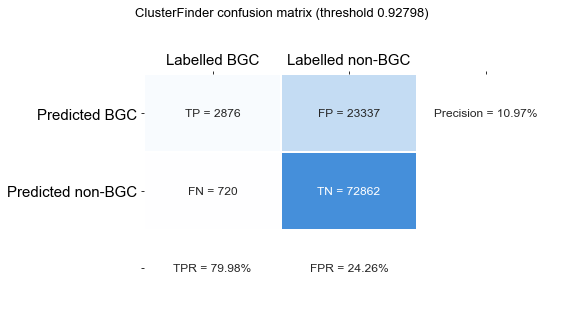

In [53]:
cf_threshold = get_threshold(predictions_cf_orig['in_cluster'], predictions_cf_orig['prediction'], target_tpr=0.8)
confusion_matrix(predictions_cf_orig['in_cluster'], predictions_cf_orig['prediction'], threshold=cf_threshold, title='ClusterFinder confusion matrix')
evaluate(get_results(predictions_cf_orig, bgcs), predictions_cf_orig, cf_threshold)